## Credit Risk Modelling

In [1]:
from zipfile import ZipFile
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import string
from sklearn.model_selection import train_test_split
import os
import statistics
import shutil
import matplotlib
import re
import warnings
from catboost import CatBoostClassifier, cv
import catboost
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
np.printoptions(pricision=2)
import pandas as pd
import itertools
pd.set_option('display.max_columns', 30)
# %matplotlib inline
warnings.filterwarnings('ignore')
# nltk.download('stopwords')
plt.style.use('ggplot')
from scipy.stats.contingency import chi2_contingency
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import boxcox, skew, kurtosis, normaltest
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import sklearn.impute
from catboost import Pool
import pickle

In [2]:
dtypes = dict(
    Month="category",
    Name="category",
    Occupation="category",
    Type_of_Loan="category",
    Credit_History_Age="category",
    Payment_Behaviour="category"
)


train_df = pd.read_csv("train.csv", dtype=dtypes, parse_dates=['Month'])
train_df["is_train"] = True
test_df = pd.read_csv("test.csv", dtype=dtypes, parse_dates=['Month'])
test_df["is_train"] = False
df = pd.concat([train_df, test_df])

In [3]:
train_df['Month'].value_counts(dropna=False)

January     12500
February    12500
March       12500
April       12500
May         12500
June        12500
July        12500
August      12500
Name: Month, dtype: int64

In [4]:
#Features available
AA=train_df.dtypes.reset_index()
AA.columns=["Col_name","Dtype"]
AA

,Col_name,Dtype
0,ID,object
1,Customer_ID,object
2,Month,object
3,Name,category
4,Age,object
5,SSN,object
6,Occupation,category
7,Annual_Income,object
8,Monthly_Inhand_Salary,float64
9,Num_Bank_Accounts,int64


### Looking for unique values in categorical columns

This code extracts and analyzes categorical columns in a DataFrame, recording statistics about their unique values, counts, and percentages of occurrence, and returns this information in a structured DataFrame.

In [5]:
def get_unique_values(df):
    cat_cols = df.select_dtypes("object").columns

    data_info = np.zeros((len(cat_cols), 5), dtype="object")
    for i, col in enumerate(cat_cols):
        if len(df[col].unique()) > 5000:
            continue
        else:
            unique_values, counts = np.unique(
                np.array(df[col], dtype=str), return_counts=True)
            num_of_uv = len(unique_values)
            unique_val_percent = np.round(counts / counts.sum(), 2)
            data_info[i, :] = [col, unique_values.tolist(), counts.tolist(), num_of_uv, unique_val_percent]
    return pd.DataFrame(data_info, columns=["column", "unique", "counts", "len_unique_values", "%_unique_values"])

In [6]:
unique_values_df = get_unique_values(df)
unique_values_df.head()

,column,unique,counts,len_unique_values,%_unique_values
0,0,0,0,0,0
1,0,0,0,0,0
2,Month,"[April, August, December, February, January, J...","[12500, 12500, 12500, 12500, 12500, 12500, 125...",12,"[0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.0..."
3,Age,"[-500, 100, 1004, 1006, 1007, 1010, 1018_, 102...","[1350, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2524,"[0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,0,0,0,0


### Data Processing with the DataProcessor Class

In [7]:
class DataProcessor:

    def __init__(self, groupby, data_frame):
        self.groupby = groupby
        self.df = data_frame


    def get_month(self, x):
     if not pd.isnull(x):
         year_month = re.findall(r"\d+", x)
         months = (int(year_month[0])*12) + np.int64(year_month[-1])
         return months
     else:
         x

    @staticmethod
    def get_numbers(text):
        digits = re.findall(r'\d+', str(text))
        digits = ','.join(digits)
        return digits

    @staticmethod
    def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        return np.nan if clean_text == "nan" else clean_text

    @staticmethod
    def preprocess_text(texts:str) -> tuple[dict, list[list[str]]]:
        dictionary = {}

        tokens = [str(text).lower().replace("and", "").split(",") for text in texts]
        tokens = [[token.strip() for token in token_list if token not in string.punctuation] for token_list in tokens]
        for token_list in tokens:
            for token in token_list:
                if token not in dictionary:
                    size = len(dictionary)
                    dictionary[token] = size
        return (dictionary, ["|".join(words) for words in tokens])


    @staticmethod
    def fill_na(df: pd.DataFrame, groupby=None):
        cat_features = df.select_dtypes(exclude="number").columns.drop(
            ["is_train", "Credit_Score", "Type_of_Loan"])
        num_features = df.select_dtypes(include="number").columns

        df["Type_of_Loan"].fillna("not specified", inplace=True)

        def fill_na_cat(df):
            df[cat_features] = df.groupby(groupby)[cat_features].transform(
                lambda x: x.fillna(x.mode()[0]))
            return df

        def fill_na_num(df):
            df[num_features] = df.groupby(groupby)[num_features].transform(
                lambda x: x.fillna(x.median()))
            return df

        df = fill_na_cat(df)
        df = fill_na_num(df)
        return df


    def preprocess(self):
        self.df['Age'] = self.df.Age.apply(DataProcessor.get_numbers)
        self.df = self.df.applymap(DataProcessor.replace_special_character)
        self.df = self.df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
        self.df["Credit_Mix"] = self.df.groupby(self.groupby)["Credit_Mix"].transform(lambda x: x.replace("", x.mode()[0]))
        self.df["Payment_Behaviour"] = self.df.groupby(self.groupby)["Payment_Behaviour"].transform(
            lambda x: x.replace("!@9#%8" if x.mode()[0] != "@9#%8" else np.nan)
        )
        self.df["Type_of_Loan"] = self.df[["Type_of_Loan"]].apply(lambda x:  DataProcessor.preprocess_text(x.values)[-1])
        self.df["Type_of_Loan"] = self.df["Type_of_Loan"].str.replace(" ", "_").str.replace("|", " ")
        self.df["Credit_History_Age"] = self.df["Credit_History_Age"].apply(lambda x: self.get_month(x))
        self.df["Monthly_Balance"] = pd.to_numeric(self.df.Monthly_Balance, errors="coerce")
        self.df = DataProcessor.fill_na(self.df, "Customer_ID")

        return self.df


In [8]:
preprocesor = DataProcessor("Customer_ID", df)
data = preprocesor.preprocess()

In [9]:
data.loc[df["Num_Bank_Accounts"]<0, "Num_Bank_Accounts"] = 0  # Replacing account balances less than zero with zero
data.loc[data["Type_of_Loan"]=="nan", "Type_of_Loan"] = np.nan  #Replace "nan" values in the 'Type_of_Loan' column with NaN for consistency
data.loc[data["Occupation"] == "", "Occupation"] = np.nan  #Replace "nan" values in the 'Occupation' column with NaN for consistency
data.loc[data["Credit_Mix"] == "", "Credit_Mix"] = np.nan  #Replace "nan" values in the 'Credit_Mix' column with NaN for consistency

### Custom Outlier Removal and Skewness Correction

The provided Python code defines a ClipOutliersTransformer class and functions for outlier removal and skewness correction within a pandas DataFrame.

**ClipOutliersTransformer Class**: This class is designed to transform numerical data by clipping outliers. It takes parameters such as lower and upper quantiles, a multiplier for defining the clipping limits, and an option to replace outliers with the median. The fit method calculates the lower and upper clipping limits based on quantiles, and the transform method applies the clipping transformation.

**get_skewness Function**: This function calculates the skewness of numerical columns in a DataFrame and categorizes them as highly skewed or lowly skewed based on user-defined skewness thresholds.

**remove_outliers Function**: This function is used to remove outliers and correct skewness in numerical columns of a DataFrame. It first identifies highly and lowly skewed columns using the get_skewness function. Then, it applies the ClipOutliersTransformer to clip outliers in highly skewed columns while replacing them with the median, and to clip outliers in lowly skewed columns without replacement.

These tools collectively provide a flexible and customizable approach to handling outliers and skewness in your dataset, allowing for improved data quality and more accurate analysis or modeling.

In [10]:
class ClipOutliersTransformer(BaseEstimator, TransformerMixin):

    def __init__(self,
                 lower_quantile,
                 upper_quantile,
                 multiply_by=1.5,
                 replace_with_median: bool = False):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.multiply_by = multiply_by
        self.replace_with_median = replace_with_median

        self.lower_limit = 0
        self.upper_limit = 0
        self.feature_names_in_ = None

    def fit(self, X, y=None):
        q1, q3 = np.quantile(X, [self.lower_quantile, self.upper_quantile])
        iqr = q3 - q1
        self.lower_limit = q1 - (self.multiply_by * iqr)
        self.upper_limit = q3 + (self.multiply_by * iqr)
        # self.feature_names_in_ = X.columns.tolist()

        return self

    def transform(self, X):
        if self.replace_with_median:
            return np.where(
                ((X >= self.lower_limit) & (X <= self.upper_limit)), X,
                np.median(X))
        else:
            return np.clip(X, self.lower_limit, self.upper_limit)


def get_skewness(df, lower=None, upper=None):
    columns = df.columns
    skewness: pd.Series = df[columns].skew()
    highly_skewed = skewness[(skewness <= lower) |
                             (skewness >= upper)].index.to_list()
    lowly_skewed = skewness[(skewness > lower)
                            & (skewness < upper)].index.to_list()
    return (highly_skewed, lowly_skewed)


def remove_outliers(df: pd.DataFrame):
    category = df.select_dtypes(exclude="number").columns.drop(["Credit_Score"])
    numbers = df.select_dtypes(include="number").columns

    highly_skewed, lowly_skewed = get_skewness(df[numbers],lower=-0.8,upper=0.8)

    df[highly_skewed] = df[highly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=True).
        fit_transform(x))

    df[lowly_skewed] = df[lowly_skewed].apply(
        lambda x: ClipOutliersTransformer(
            0.25, 0.75, multiply_by=1.5, replace_with_median=False).
        fit_transform(x))
    return df

In [11]:
data = remove_outliers(data)

In [12]:
def make_boxplot(df, column, ax):
    sns.boxplot(x="Credit_Score", y=column, data=df, ax=ax, width=0.8, palette="Set2")
    plt.xticks(rotation=90)
    # add the five number summary to the plot
    plt.title(column, fontdict={"fontsize": 10})
    plt.xticks(rotation=0)

In [13]:
matplotlib.rc(("xtick", "ytick", "text"), c="k")
matplotlib.rc("figure", dpi=80)

In [14]:
def plot_boxplot_num_cols(df):
    fig = plt.figure(figsize=(18, 14), dpi=300)
    numb_columns = df.select_dtypes(include="number").columns
    for column in numb_columns:
        ax = fig.add_subplot(5, 4, list(numb_columns).index(column)+1)
        make_boxplot(df, column, ax)
        plt.tight_layout(pad=0.3)
    plt.tight_layout()
    plt.show()

###Data Visualization with Box Plots and Intuition

The provided Python code defines functions for creating box plots, which are a powerful visualization tool for understanding the distribution of numerical data.

Box Plots Intuition: Box plots provide a graphical representation of the data's central tendency, spread, and potential outliers. The "box" in the plot represents the interquartile range (IQR), which encompasses the middle 50% of the data. The line inside the box denotes the median (50th percentile), while the "whiskers" extend to the minimum and maximum values within a defined range or to the nearest data points within a certain distance from the quartiles. Any data points outside the whiskers are considered outliers and are plotted individually.

make_boxplot Function: This function creates a box plot for a specified numerical column against the 'Credit_Score' column in the DataFrame. It allows us to visually assess how the values of a particular numerical variable are distributed within different credit score groups.

plot_boxplot_num_cols Function: This function automates the creation of multiple box plots for all numerical columns in the DataFrame, making it easier to compare the distributions of various numerical features.

By using box plots, you can quickly identify potential outliers, assess the central tendency and spread of data, and gain insights into the overall distribution of numerical variables, aiding in data exploration and decision-making in data analysis and modeling.

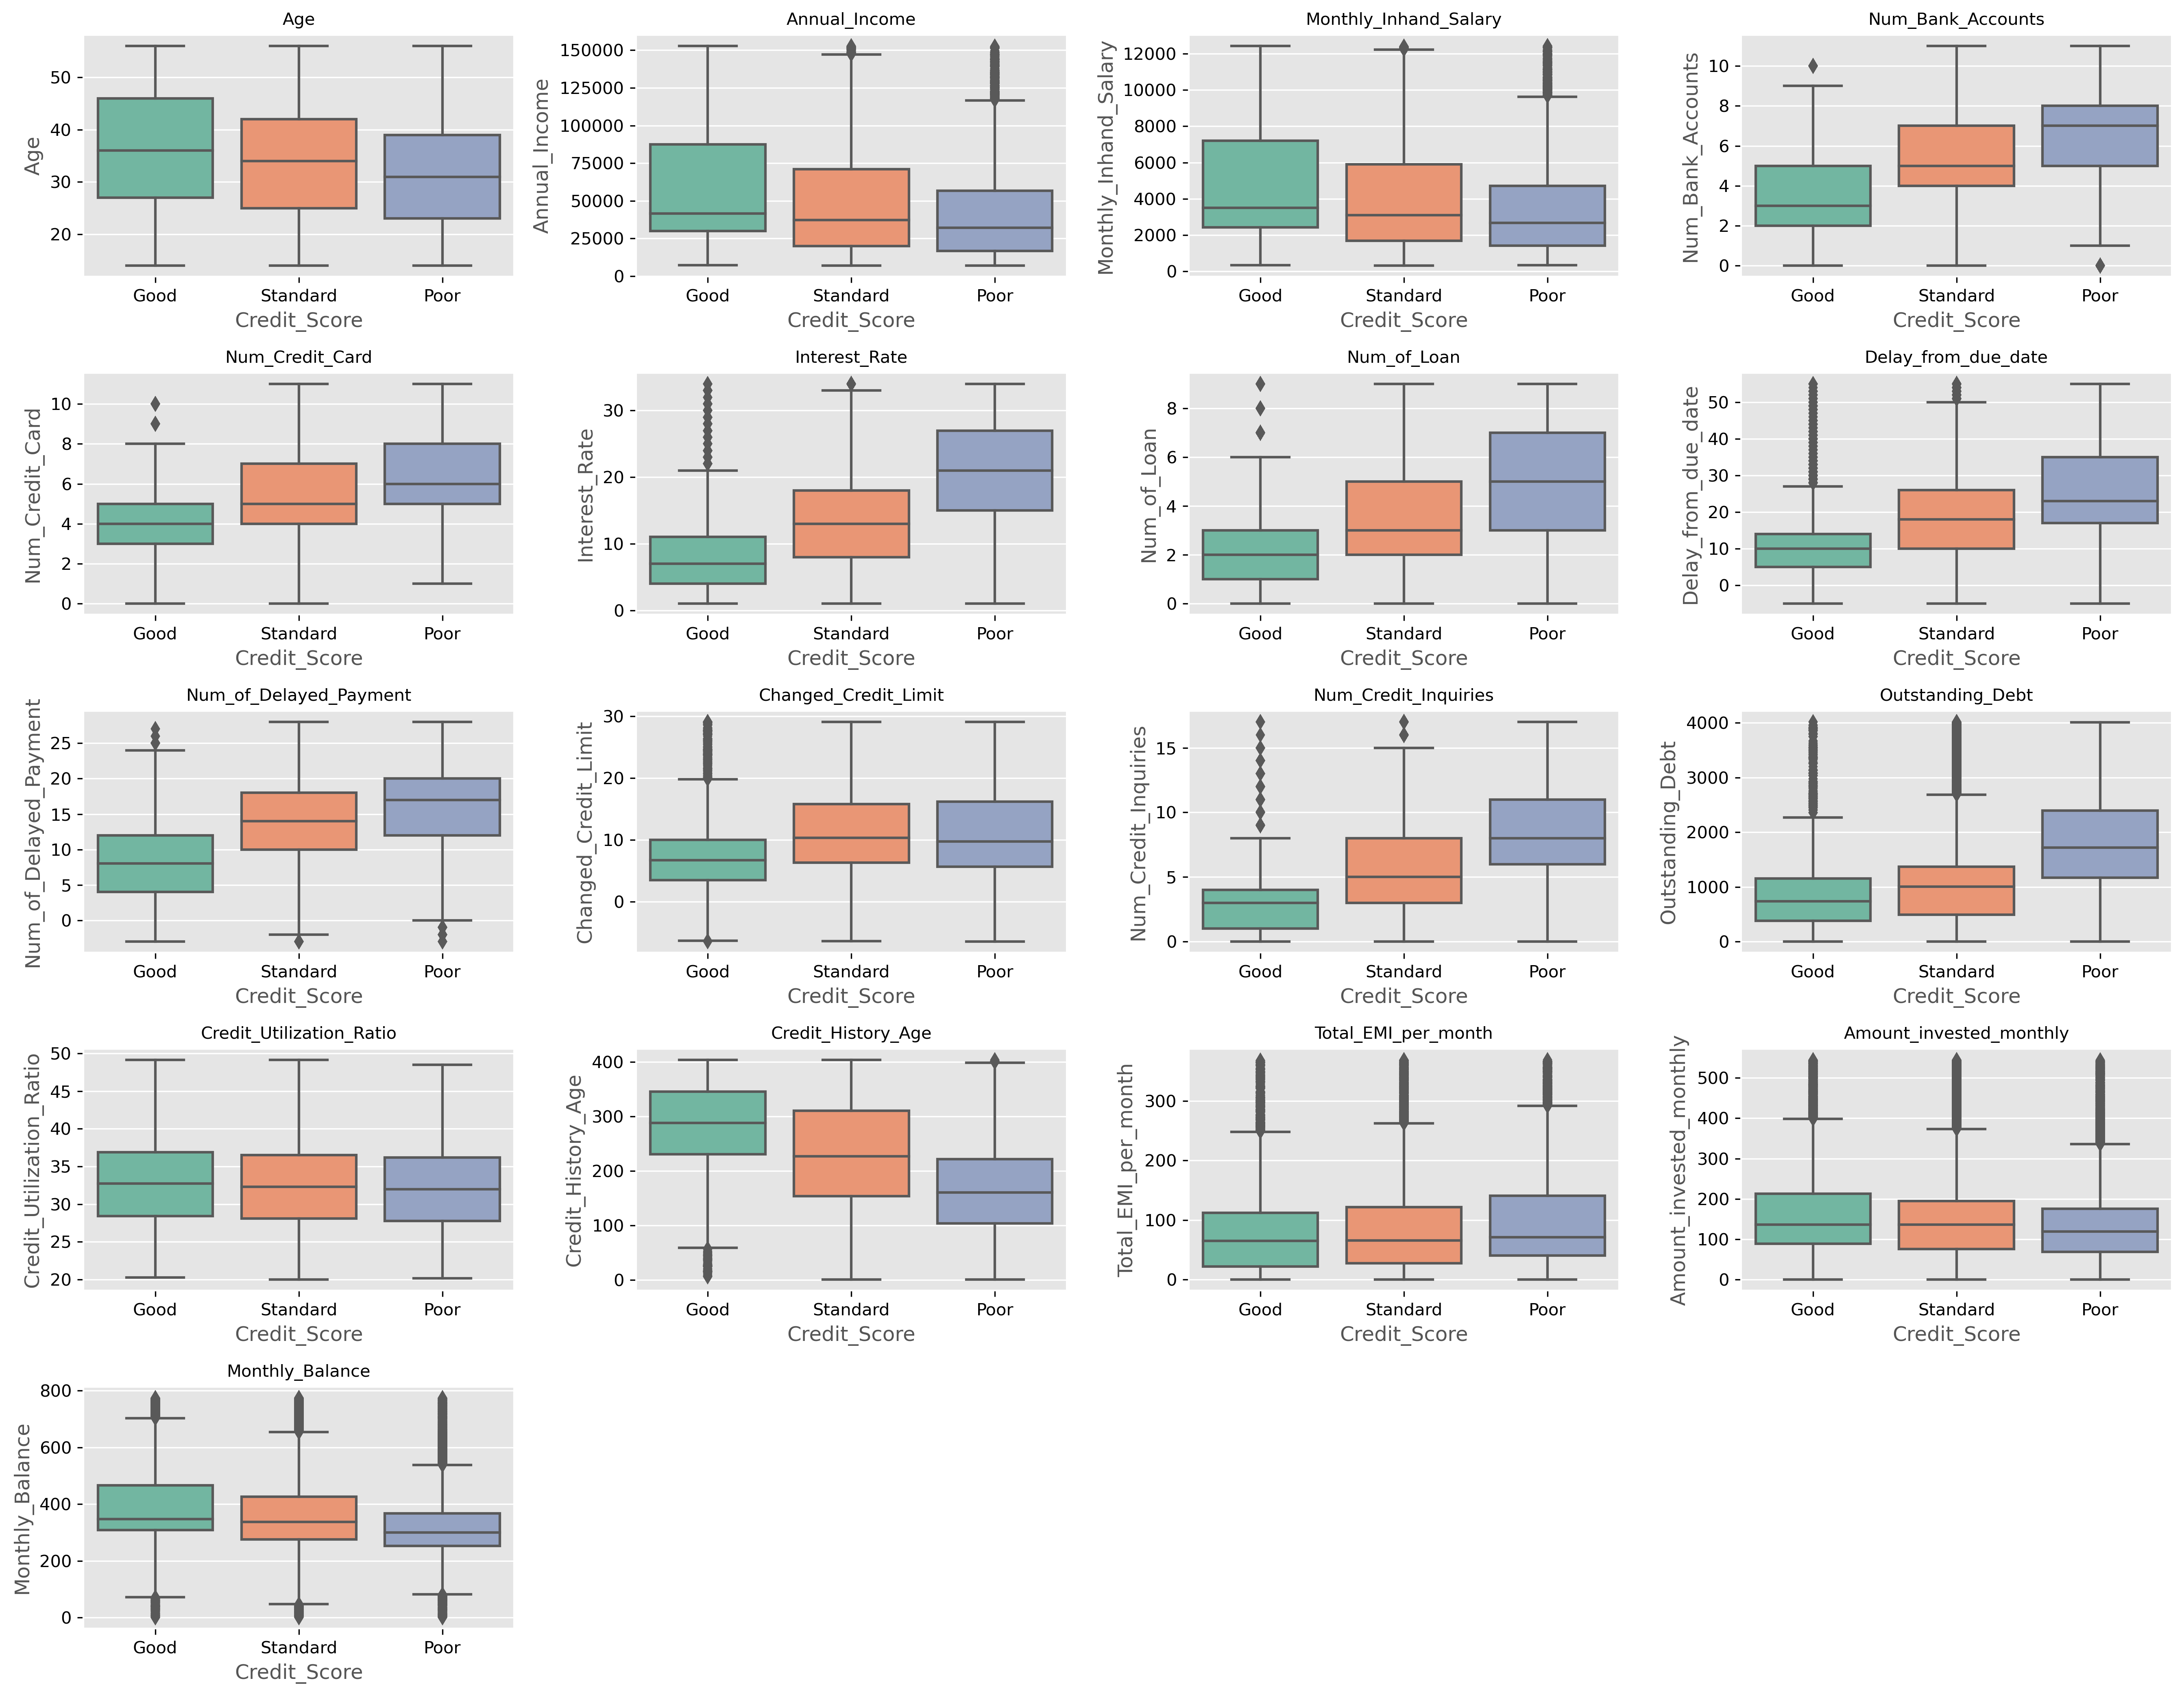

In [15]:
plot_boxplot_num_cols(data)

<Axes: xlabel='Credit_Mix', ylabel='count'>

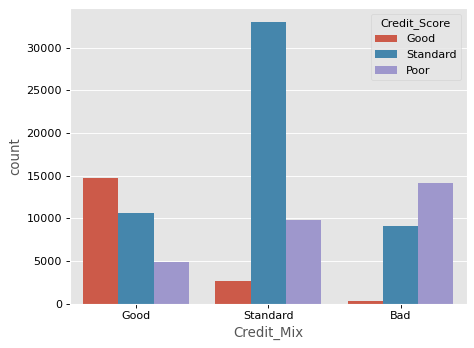

In [16]:
data = data.reset_index()
sns.countplot(data=data, x="Credit_Mix", hue="Credit_Score")

In [17]:
data.to_csv("clean_data_credit.csv", index=False)

### Reading the cleaned data set

In [19]:
df = pd.read_csv("clean_data_credit.csv")

In [20]:
df_copy = data.copy()
df_copy["Monthly_Balance"] = df_copy.groupby("Customer_ID")["Monthly_Balance"].transform(lambda x: np.where((x>np.quantile(x, 0.75)) | x<np.quantile(x, 0.25), np.median(x), x))

In [21]:
cross_tab = pd.crosstab(values=df_copy["Monthly_Balance"], index=[df_copy["Credit_Score"],
df_copy["Credit_Mix"]], columns="Monthly_Balance", aggfunc="mean").reset_index()

main_group = pd.pivot_table(cross_tab, "Monthly_Balance", "Credit_Score", aggfunc=np.mean)
cross_tab

col_0,Credit_Score,Credit_Mix,Monthly_Balance
0,Good,Bad,296.320348
1,Good,Good,403.335501
2,Good,Standard,387.642526
3,Poor,Bad,300.345681
4,Poor,Good,401.109600
5,Poor,Standard,343.470179
6,Standard,Bad,290.381714
7,Standard,Good,397.612596
8,Standard,Standard,387.203665


In [22]:
b = plt.cm.Blues
a = plt.cm.Accent
# k = plt.cm.Blues(100, 0.9)

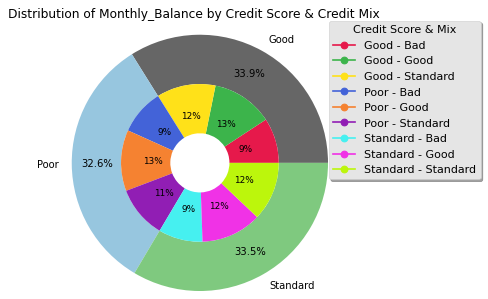

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
fig.suptitle("Distribution of Monthly_Balance by Credit Score & Credit Mix",
             fontsize=11,
             color="k")
# fig.patch.set_alpha(0)
# fig.patch.set_facecolor("#ff9999")
fig.set_frameon(True)

pie1, *_, texts = ax.pie(x=main_group["Monthly_Balance"],
                         labels=main_group.index,
                         autopct="%.1f%%",
                         radius=1.3,
                         colors=[a(80, 1), b(100, 1),
                                 a(0, 1)],
                         pctdistance=0.8,
                         textprops={"size": 9},
                         frame=True)
plt.setp(pie1, width=0.5)
ax.set_frame_on(True)

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']  # Example color list

pie2, *_, texts = ax.pie(x=cross_tab["Monthly_Balance"],
                         autopct="%.0f%%",
                         radius=0.8,
                         colors=colors[:len(cross_tab)],
                         textprops={"size": 8})
plt.setp(pie2, width=0.5)
legend_labels = np.unique(cross_tab["Credit_Mix"])

legend_labels = cross_tab[["Credit_Score", "Credit_Mix"]].apply(lambda row: f"{row['Credit_Score']} - {row['Credit_Mix']}", axis=1).unique()

legend_handles = [plt.plot([], [], marker="o", color=colors[i], label=label)[0] for i, label in enumerate(legend_labels)]

plt.legend(handles=legend_handles, shadow=True, frameon=True, facecolor="inherit", loc="best", title="Credit Score & Mix", bbox_to_anchor=(1, 1, 0.5, 0.1))

plt.show()

In [24]:
def make_countplot(df: pd.DataFrame):

    cat_cols = df.select_dtypes(exclude="number").columns.drop(
        ['Credit_Score', 'is_train', 'Customer_ID', "Type_of_Loan"])
    cat_cols = list(cat_cols)
    cat_cols.pop(-1)
    cat_cols.insert(-2, "Payment_Behaviour")

    fig, axes = plt.subplots(figsize=(12, 6), dpi=300)
    fig.suptitle("Counts of categorical columns")
    axes.grid(visible=False)
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.set_tick_params(labelleft=False)

    def __plot_graph(df, col, ax: plt.Axes, legend=False):
        sns.countplot(
            data=df,
            x=col,
            ax=ax,
            hue="Credit_Score",
        )
        # label =ax.get_xlabel()
        ax.set_xlabel(col, fontdict={"size": 9})
        ax.set_title(f"by {col}", fontdict={"size": 9})
        ax.get_xticklabels()
        ax.tick_params(labelsize=7, axis="y")
        ax.set_xticklabels(ax.get_xticklabels(),
                           rotation=90,
                           fontdict=dict(size=7))
        ax.grid(False)
        if legend:
            ax.legend(shadow=True,
                      loc="best",
                      facecolor="inherit",
                      frameon=True)
        else:
            ax.legend_ = None
        plt.tight_layout(w_pad=1)

    for i, col in enumerate(cat_cols, 1):
        if i == 3:
            continue
        ax = fig.add_subplot(2, 3, i)
        __plot_graph(df, col=col, ax=ax)

    ax2 = fig.add_axes((0.74, 0.527, 0.23, 0.35))
    __plot_graph(df, col="Payment_Behaviour", ax=ax2, legend=True)
    plt.show(True)

#### Correlation Heatmap and Intuition

The provided Python code calculates and visualizes the correlation matrix of numerical features in the dataset, excluding the "is_train" column. Here's the intuition behind the code:

**Correlation Matrix**: The code computes a correlation matrix (corr) that quantifies the linear relationships between pairs of numerical features. Each cell in the matrix represents the correlation coefficient, which can range from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

**Masking the Upper Triangle**: To enhance clarity, the code applies a mask (mask) to hide the upper triangular part of the matrix. This is because the correlation matrix is symmetric, and the upper triangle contains redundant information.

**Heatmap Visualization**: The sns.heatmap function from the Seaborn library is used to create a heatmap of the correlation matrix. Annotations in the heatmap display the correlation coefficients as percentages. The resulting visualization provides a quick overview of how numerical features relate to each other, helping identify strong correlations (either positive or negative) and potential multicollinearity in the data.

**Intuition**: By examining the heatmap, you can gain insights into which pairs of features are highly correlated. Positive correlations suggest that when one feature increases, the other tends to increase as well, while negative correlations indicate an inverse relationship. Understanding these relationships can inform feature selection, identify redundant features, and guide feature engineering during data analysis or modeling.

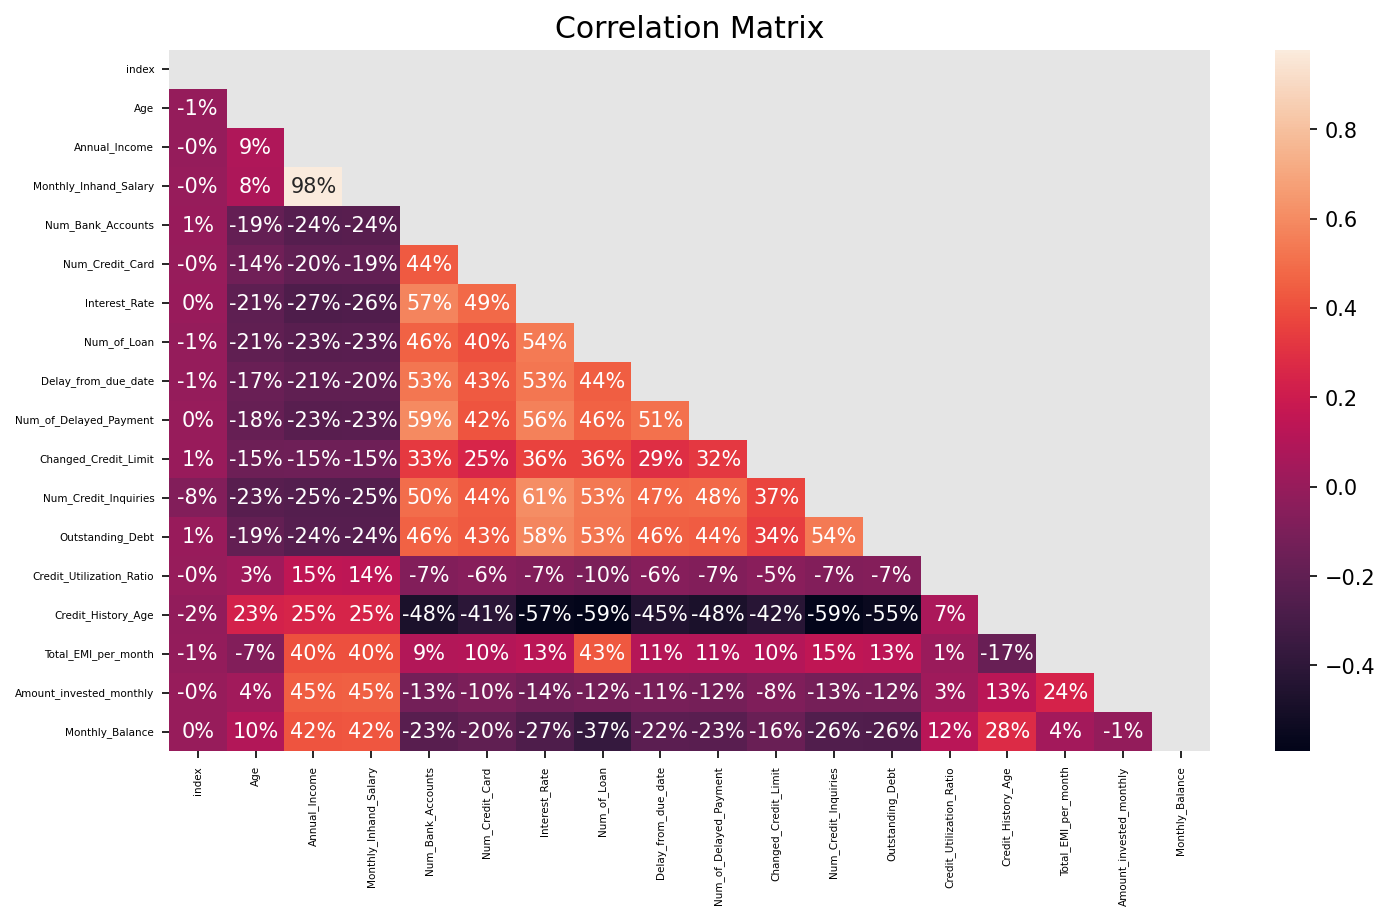

In [25]:
corr = data.drop(["is_train"], axis=1).corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))

fig = plt.figure(figsize=(10, 6), dpi=150)

sns.heatmap(corr, annot=True, mask=mask, fmt=".0%", annot_kws={"size":10})
plt.grid(False)
plt.tick_params(axis="both", labelsize=5)
plt.tight_layout()
plt.title("Correlation Matrix")
plt.show()

In [26]:
df.loc[~df["is_train"], "Month"].value_counts()

September    12500
October      12500
November     12500
December     12500
Name: Month, dtype: int64

####Hypothesis Testing with Chi-Square and F-Tests

This Python code defines a chi_2_test function that conducts hypothesis testing to assess the relationship between categorical and numerical columns in a DataFrame and the target variable 'Credit_Score.'

**Function Purpose**: The chi_2_test function first prepares a copy of the DataFrame with only training data and selects categorical and numerical columns of interest. It then initializes an empty NumPy array to store test results. The function performs two types of tests: Chi-Square tests for categorical columns and F-tests (ANOVA) for numerical columns to assess their significance in explaining 'Credit_Score' variations.

**Hypothesis Testing**: The Chi-Square test evaluates the independence between categorical variables and 'Credit_Score,' while the F-tests assess the variance in 'Credit_Score' explained by numerical variables. The results include the test statistic and p-value for each column, helping identify significant factors influencing 'Credit_Score.'

This function provides valuable insights into how different features relate to 'Credit_Score,' aiding in feature selection and understanding the dataset's predictive power in credit scoring analysis or modeling.

In [27]:
def chi_2_test(df:pd.DataFrame):
    df_copy = df.loc[df["is_train"]].copy()
    cat_cols = df_copy.select_dtypes(exclude="number").columns.drop(["Customer_ID", "Month", "is_train", "Credit_Score"])
    numb_columns = df_copy.select_dtypes(include="number").columns

    summary = np.empty((len(cat_cols)+len(numb_columns), 3), dtype="object")
    y, *_ = df_copy["Credit_Score"].factorize(sort=False)

    def perform_test(*args, test):

        if test == "chi2":
            for i, col in enumerate(args[0]):
                cross = pd.crosstab(index=df[col], columns=[df["Credit_Score"]])
                t_stat, pvalue, *_ = chi2_contingency(cross)
                summary[i, :] = [col, t_stat, pvalue]

        elif test=="f_classif":
            for i, col in enumerate(args[0], start=len(summary)-len(args[0])):
                t_stat, pvalue = f_classif(df_copy[[col]], y.reshape(-1, 1))
                summary[i, :] = [col, t_stat[0], pvalue[0]]

    perform_test(cat_cols, test="chi2")
    perform_test(numb_columns, test="f_classif")

    return pd.DataFrame(
        data=summary,
        columns=["column", 't-statistic', "p-value"]
    )

In [28]:
data.drop(["Name", "SSN", "ID", "index"], axis=1, inplace=True, errors="ignore")

In [29]:
chi2_summary = chi_2_test(data).sort_values(by="t-statistic", ascending=False)

In [30]:
chi2_summary.style.bar("t-statistic").background_gradient(
    "Blues", subset="t-statistic")

,column,t-statistic,p-value
1,Type_of_Loan,65283.448081,0.000000
2,Credit_Mix,39939.333264,0.000000
3,Payment_of_Min_Amount,16869.960993,0.000000
10,Interest_Rate,14942.672179,0.000000
15,Num_Credit_Inquiries,11640.610032,0.000000
16,Outstanding_Debt,10172.739505,0.000000
12,Delay_from_due_date,9775.596949,0.000000
9,Num_Credit_Card,9472.156733,0.000000
8,Num_Bank_Accounts,9148.775200,0.000000
18,Credit_History_Age,8902.256599,0.000000


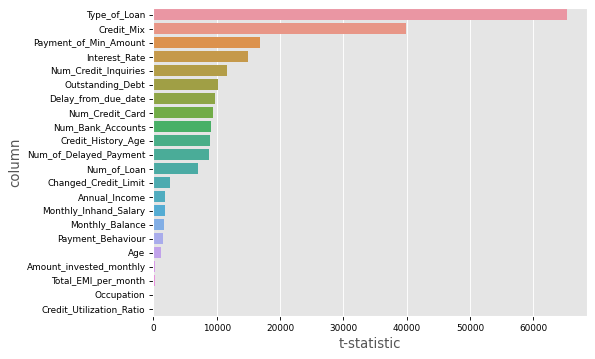

In [31]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=chi2_summary, y="column", x="t-statistic", ax=ax)
plt.setp([ax.get_xticklabels(), ax.get_yticklabels()], size=8)
fig.show()

####Data Transformation with Custom Pipelines

This Python code defines a data transformation function, transform_columns, which utilizes custom pipelines for preprocessing categorical and numerical columns in a DataFrame.

**Column Selection**: The function first identifies categorical and numerical columns within the DataFrame, categorizing them into two separate lists.

**Custom Pipelines**: It then defines two custom pipelines using scikit-learn's Pipeline class: one for numerical columns and another for categorical columns. The numerical pipeline imputes missing values with the median using IterativeImputer and scales the features to a consistent range using MinMaxScaler. The categorical pipeline imputes missing values with the most frequent value using SimpleImputer.

**ColumnTransformer**: The pipelines are integrated into a ColumnTransformer object that applies the defined transformations to their respective columns, while the "remainder" parameter specifies that any untransformed columns should be dropped.

This function provides a flexible and structured way to preprocess categorical and numerical data separately, preparing it for downstream analysis or modeling tasks. It allows for customization of imputation strategies and ensures consistent scaling for numerical features.

In [32]:
def transform_columns(data_frame: pd.DataFrame):
    category = data_frame.select_dtypes(exclude="number").columns.tolist()
    number =data_frame.select_dtypes(include="number").columns.tolist()


    def build_pipeline_numb(strategy="median"):
        pipe1 = Pipeline(steps=[
            ("imputer", IterativeImputer(initial_strategy=strategy, random_state=42)),
            ("scaling", MinMaxScaler()),
            # ("pca", PCA(0.98))
            # ("scaling", PowerTransformer())

        ])
        return pipe1

    def build_pipeline_cat(strategy="most_frequent"):
        pipe2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy=strategy))
])
        return pipe2

    transformer = ColumnTransformer(
        [
            ("cat_transformer", build_pipeline_cat(), category),
            ("numb_transformer", build_pipeline_numb(), number)
        ],
        remainder="drop"
    )
    transformer.fit(data_frame)
    return transformer

In [33]:
def split_data(data: pd.DataFrame, test_size=0.2) -> tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    df_copy = data.copy()
    df_copy.drop(columns = ["Month", "Customer_ID"], inplace=True)
    df_copy["Delay_from_due_date"] = df_copy["Delay_from_due_date"].abs()

    train_set = df_copy[df_copy["is_train"]].drop(["is_train"], axis=1)
    test_set = df_copy[df_copy["is_train"] == False].drop(
        ["is_train", "Credit_Score"], axis=1).reset_index(drop=True)

    X = train_set.drop("Credit_Score", axis=1)
    y = train_set.pop("Credit_Score")

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size, stratify=y, random_state=2, shuffle=True)
    return ((Xtrain, Xtest, ytrain, ytest), test_set)


def combined_transformers(data, save_to_pickle=False):
    outlier_remover = ClipOutliersTransformer(0.25, 0.75, multiply_by=1.5, replace_with_median=False)
    outlier_remover.fit(data.select_dtypes("number"))
    transformer = transform_columns(data)
    if save_to_pickle:
        file1 = open("OutlierRemover.pkl", "wb")
        file2 = open("ColumnsTransformers.pkl", "wb")
        pickle.dump(outlier_remover, file1)
        pickle.dump(transformer, file2)
    return (outlier_remover, transformer)


def get_transformed_data(data, transformers_to_pkl=False) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # transformer = kwargs.get("transformer")
    train_set, test_set = split_data(data)
    Xtrain, Xtest, ytrain, ytest = train_set
    _, transformer = combined_transformers(Xtrain, save_to_pickle=transformers_to_pkl)

    columns = list(itertools.chain.from_iterable([transformer[-1] for transformer in transformer.__dict__.get("transformers")]))
    Xtrain = pd.DataFrame(transformer.transform(Xtrain), columns=columns).apply(pd.to_numeric, errors="ignore")
    Xtest = pd.DataFrame(transformer.transform(Xtest), columns=columns).apply(pd.to_numeric, errors="ignore")
    test_set = pd.DataFrame(transformer.transform(test_set), columns=columns).apply(pd.to_numeric, errors="ignore")
    return ((Xtrain, Xtest), (ytrain, ytest), test_set)


In [34]:
((Xtrain, Xtest), (ytrain, ytest), test_set) = get_transformed_data(data, transformers_to_pkl=True)

cat_columns = Xtrain.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

####CatBoost Model Training Functions

These Python functions are designed for training CatBoost models efficiently in machine learning tasks:

**create_pool Function**: This function prepares training and testing data by creating CatBoost Pools, which are optimized data structures for CatBoost models. It takes input features (xtrain, ytrain, xtest, ytest), categorical features (cat_features), and text features (text_features) as arguments and returns the corresponding CatBoost Pools for training and testing data.

**catboost_model Function**: This function configures a CatBoostClassifier with default and custom parameters, such as the number of iterations, custom evaluation metrics, and multi-threading settings. Users can provide additional parameters to customize the model further.

**fit_model Function**: The main training function that combines the previous two functions. It creates the data pools, configures the CatBoost model, fits the model to the training data while evaluating on the testing data, and allows for early stopping and additional keyword arguments.

These functions streamline the process of training CatBoost models, making it easier to handle data preparation, model configuration, and training with customizable options.

In [35]:
def create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features):
    Xtrain_pool = Pool(data=xtrain, label=ytrain, cat_features=cat_features, text_features=text_features)
    Xtest_pool = Pool(data=xtest, label=ytest, cat_features=cat_features, text_features=text_features)
    return (Xtrain_pool, Xtest_pool)


def catboost_model(params = {}):
    cb_params = {
        "iterations": 10000,
        "custom_metric": ["F1", "AUC", "Accuracy"],
        "thread_count":-1,
        "random_state": 42,
        "train_dir": "/catboost"

    }
    cb_params.update(params)

    model = CatBoostClassifier(**cb_params)
    return model


def fit_model(xtrain, ytrain, xtest, ytest, cat_features, text_features, params = {}, **kwargs):
    Xtrain_pool, Xtest_pool = create_pool(xtrain, ytrain, xtest, ytest, cat_features, text_features)
    model = catboost_model(params = params)
    model.fit(Xtrain_pool, eval_set=Xtest_pool, early_stopping_rounds=500, **kwargs)
    return model


####CatBoost Classifier Training

The provided Python code defines a function, fit_catboost, for training a CatBoost classifier on labeled data. This function takes training and testing data along with various parameters like categorical and text features, as well as optional custom parameters for the CatBoost model.

**Data Preparation**: The function first creates CatBoost Pools for both the training and testing data, considering categorical and text features. These pools are optimized data structures that CatBoost uses for efficient training.

**Model Configuration and Training**: It configures the CatBoostClassifier, including the number of iterations, custom metrics, and multithreading settings, and then fits the model to the training data while evaluating it on the testing data. The "early_stopping_rounds" parameter allows for early stopping to prevent overfitting.

**Customization**: The function allows users to specify additional CatBoost parameters through the "params" argument and control the verbosity of training with the "verbose" argument. It also provides the option to visualize training progress with the "plot" parameter.

This function simplifies the process of training a CatBoost classifier, making it accessible for classification tasks while offering customization options for advanced users.

In [36]:
model = fit_model(
    Xtrain, ytrain,
    Xtest, ytest,
    cat_columns, text_column,
    plot=False,
    verbose=500,
    params = {
        "text_processing": ["NaiveBayes+Word|BoW+Word"],
        "task_type": "CPU",
        "one_hot_max_size": 3,
        "depth": 6,
        "auto_class_weights": "Balanced",
        "bootstrap_type": "Bayesian", # Keep bootstrap_type as Bayesian
        # "subsample":0.5,  # Remove the subsample parameter
        "max_bin": 100,
        "allow_writing_files": False

    }
)

Learning rate set to 0.048909
0:	learn: 1.0662154	test: 1.0665770	best: 1.0665770 (0)	total: 96.3ms	remaining: 16m 2s
500:	learn: 0.6162576	test: 0.6471991	best: 0.6471991 (500)	total: 17.8s	remaining: 5m 36s
1000:	learn: 0.5617282	test: 0.6123725	best: 0.6123725 (1000)	total: 35.2s	remaining: 5m 16s
1500:	learn: 0.5231416	test: 0.5889274	best: 0.5889274 (1500)	total: 52.7s	remaining: 4m 58s
2000:	learn: 0.4916857	test: 0.5720175	best: 0.5720175 (2000)	total: 1m 10s	remaining: 4m 40s
2500:	learn: 0.4649711	test: 0.5580651	best: 0.5580651 (2500)	total: 1m 27s	remaining: 4m 22s
3000:	learn: 0.4429781	test: 0.5471912	best: 0.5471912 (3000)	total: 1m 46s	remaining: 4m 7s
3500:	learn: 0.4226307	test: 0.5368484	best: 0.5368484 (3500)	total: 2m 4s	remaining: 3m 50s
4000:	learn: 0.4051813	test: 0.5291853	best: 0.5291853 (4000)	total: 2m 21s	remaining: 3m 32s
4500:	learn: 0.3898724	test: 0.5234771	best: 0.5234641 (4499)	total: 2m 38s	remaining: 3m 14s
5000:	learn: 0.3753274	test: 0.5181536	best

In [37]:
model.save_model("credit_score_prediction_model.cbm")

Accuracy: 79.20%
F1 Score: {'Good': '74.51%', 'Poor': '81.26%', 'Standard': '79.88%'}
Precision Score: {'Good': '66.22%', 'Poor': '77.47%', 'Standard': '87.04%'}
Recall Score: {'Good': '85.17%', 'Poor': '85.45%', 'Standard': '73.80%'}



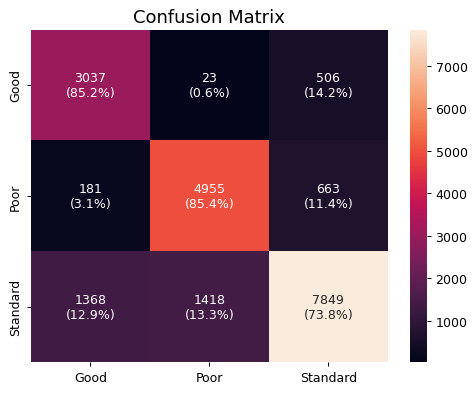

In [38]:
loaded_model = CatBoostClassifier()
loaded_model.load_model(r"credit_score_prediction_model.cbm")

y_hat = loaded_model.predict(Xtest[loaded_model.feature_names_])
acc_score = accuracy_score(ytest, y_hat)
f1 = f1_score(ytest, y_hat, average=None)
precision = precision_score(ytest, y_hat, average=None)
recall = recall_score(ytest, y_hat, average=None)

print(f"Accuracy: {acc_score:.2%}\n\
F1 Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', f1)))}\n\
Precision Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', precision)))}\n\
Recall Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', recall)))}\n\
")


cm = confusion_matrix(ytest, y_hat)
cm_norm = confusion_matrix(ytest, y_hat, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=loaded_model.classes_, yticklabels=loaded_model.classes_)
plt.title("Confusion Matrix")
plt.show()

In [39]:
model.save_model("credit_score_prediction_model")

In [40]:
Xtrain_pool, Xtest_pool = create_pool(Xtrain, ytrain, Xtest, ytest, cat_columns, text_column)

In [41]:
importance = model.get_feature_importance(Xtest_pool, type="LossFunctionChange", prettified=True)

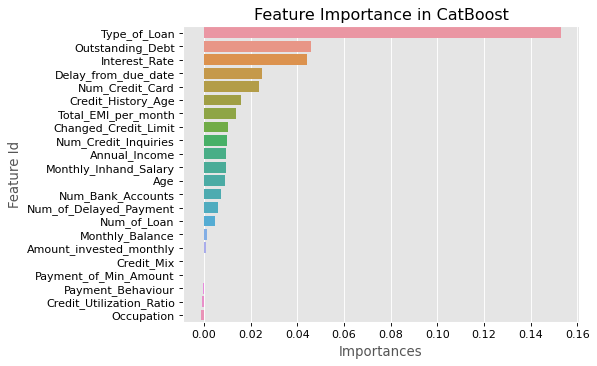

In [42]:
sns.barplot(data=importance, y="Feature Id", x = "Importances")
plt.title("Feature Importance in CatBoost")
plt.show()

#### Hyper parmaeter tuning

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

catboost_model_ = CatBoostClassifier(verbose=0, random_seed=42)

param_grid = {
    'iterations': [50,100,200],
    'learning_rate': [0.01, 0.03, 0.1, 0.2],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64]
}

tuner = RandomizedSearchCV(
    estimator=catboost_model_,
    param_distributions=param_grid,
    n_iter=3,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

for col in Xtrain.select_dtypes(include=['object']).columns:
    Xtrain[col] = Xtrain[col].str.decode('utf-8') if Xtrain[col].dtype == 'object' else Xtrain[col]
for col in cat_columns:
    Xtrain[col] = Xtrain[col].fillna('nan').astype(str)


tuner.fit(Xtrain, ytrain, cat_features=cat_columns)

print("Best Parameters:", tuner.best_params_)
print("Best AUC Score:", tuner.best_score_)

best_catboost_model = tuner.best_estimator_
best_params = tuner.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Parameters: {'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 200, 'depth': 8, 'border_count': 64}
Best AUC Score: 0.697925


####Model Refinement with Feature Selection

In this Python code snippet, feature selection and model refinement are performed for machine learning tasks.

**Feature Selection**: It starts by creating a copy of the dataset (df_copy) with low-importance features removed using a condition based on feature importances. This preprocessing step helps focus on the most relevant features for modeling.

**Data Transformation**: The data is then transformed using a function get_transformed_data, which prepares the training and testing sets along with specific transformers. This step ensures the data is ready for modeling.

**Model Refinement**: A machine learning model is trained using the refined dataset (Xtrain1, ytrain1) and relevant categorical (cat_columns) and text (text_column) features. The model is fine-tuned with specific parameters, including text processing methods, task type (GPU), class weights, and maximum depth, enabling better predictive performance.

This code showcases a systematic approach to feature selection and model refinement, enhancing the effectiveness of machine learning models for predictive tasks.

In [44]:
df_copy = data.copy().drop(importance.query("Importances < 0.000")["Feature Id"], axis=1)
((Xtrain1, Xtest1), (ytrain1, ytest1), test_set) = get_transformed_data(df_copy, transformers_to_pkl=True)

cat_columns = Xtrain1.select_dtypes(exclude="number").columns.drop(["Type_of_Loan"]).tolist()
text_column = ["Type_of_Loan"]

In [48]:
model_refined = fit_model(
    Xtrain1, ytrain1,
    Xtest1, ytest1,
    cat_columns, text_column,
    plot=False,
    verbose=500,
    params = {
        "text_processing": ["NaiveBayes+Word|BoW+Word"],
        "task_type": "CPU",
        "one_hot_max_size": 3,
        "auto_class_weights": "Balanced",
        #"max_depth": 7,
        "bootstrap_type": "Bayesian",
        #"max_bin": 100,
        "allow_writing_files": False,
        **best_params
    }
)


0:	learn: 1.0777039	test: 1.0779889	best: 1.0779889 (0)	total: 42ms	remaining: 8.36s
199:	learn: 0.6609610	test: 0.6804499	best: 0.6804499 (199)	total: 7.54s	remaining: 0us

bestTest = 0.6804498689
bestIteration = 199



In [49]:
model_refined.save_model("credit_score_prediction_model-cb-v1")

####Model Evaluation

In [50]:
loaded_model = CatBoostClassifier()
loaded_model.load_model(r"credit_score_prediction_model-cb-v1")

Accuracy: 68.14%
F1 Score: {'Good': '63.07%', 'Poor': '70.71%', 'Standard': '68.91%'}
Precision Score: {'Good': '51.39%', 'Poor': '63.99%', 'Standard': '85.53%'}
Recall Score: {'Good': '81.63%', 'Poor': '79.01%', 'Standard': '57.70%'}



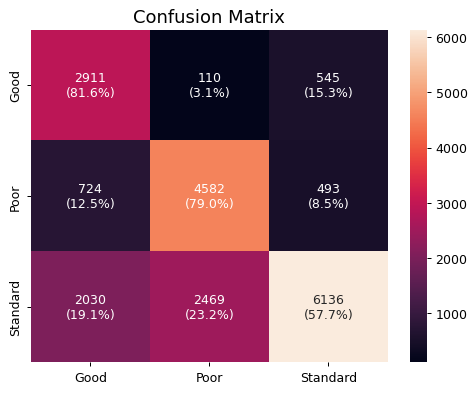

In [51]:
y_hat = loaded_model.predict(Xtest[loaded_model.feature_names_])
acc_score = accuracy_score(ytest, y_hat)
f1 = f1_score(ytest, y_hat, average=None)
precision = precision_score(ytest, y_hat, average=None)
recall = recall_score(ytest, y_hat, average=None)

print(f"Accuracy: {acc_score:.2%}\n\
F1 Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', f1)))}\n\
Precision Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', precision)))}\n\
Recall Score: {dict(zip(loaded_model.classes_, map(lambda x: f'{x:.2%}', recall)))}\n\
")


cm = confusion_matrix(ytest, y_hat)
cm_norm = confusion_matrix(ytest, y_hat, normalize="true")
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

fig = plt.figure(dpi=90)
sns.heatmap(cm, annot=annot, fmt="", xticklabels=loaded_model.classes_, yticklabels=loaded_model.classes_)
plt.title("Confusion Matrix")
plt.show()

In [52]:
print(classification_report(ytest1, model_refined.predict(Xtest1)))

              precision    recall  f1-score   support

        Good       0.51      0.82      0.63      3566
        Poor       0.64      0.79      0.71      5799
    Standard       0.86      0.58      0.69     10635

    accuracy                           0.68     20000
   macro avg       0.67      0.73      0.68     20000
weighted avg       0.73      0.68      0.68     20000



### SCOPE OF IMPROVEMENT-- IMPLEMENTATION OF ARTIFICIAL NUERAL NETWORKS

In [53]:
# Compute class_weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(ytrain), y=ytrain)
class_weights = {i: weight for i, weight in zip(np.unique(ytrain), class_weights_array)}

In [54]:
# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1

In [64]:
numeric_columns = Xtrain.select_dtypes(include=['number']).columns.tolist()
categorical_columns = Xtrain.select_dtypes(include=['object', 'category']).columns.tolist()

In [65]:
print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

Numeric columns: ['Type_of_Loan', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
Categorical columns: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']


In [69]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
import pandas as pd

#Step 1: Preprocess `Type_of_Loan` for both train and test
def preprocess_type_of_loan(df):
    df = df.copy()
    df['Type_of_Loan'] = df['Type_of_Loan'].fillna('')  # Handle missing
    df['Type_of_Loan'] = df['Type_of_Loan'].apply(lambda x: x.split())
    return df

Xtrain = preprocess_type_of_loan(Xtrain)
Xtest = preprocess_type_of_loan(Xtest)

# Step 2: Separate the columns
numeric_columns = [
    'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
    'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'
]

categorical_columns = [
    'Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour'
    # 'Type_of_Loan' is handled separately
]

# Step 3: Scale numeric & encode categorical (excluding Type_of_Loan)
basic_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

# Step 4: Transform everything
Xtrain_basic = basic_transformer.fit_transform(Xtrain)
Xtest_basic = basic_transformer.transform(Xtest)

# Step 5: Binarize the multi-label `Type_of_Loan` column
mlb = MultiLabelBinarizer(sparse_output=False)
Xtrain_loan = mlb.fit_transform(Xtrain['Type_of_Loan'])
Xtest_loan = mlb.transform(Xtest['Type_of_Loan'])

# Step 6: Combine all parts
import numpy as np
X_train_scaled = np.hstack([Xtrain_basic.toarray() if hasattr(Xtrain_basic, "toarray") else Xtrain_basic, Xtrain_loan])
X_test_scaled = np.hstack([Xtest_basic.toarray() if hasattr(Xtest_basic, "toarray") else Xtest_basic, Xtest_loan])


In [71]:
print(type(X_train_scaled), X_train_scaled.dtype)
print(type(ytrain), ytrain.dtype)

<class 'numpy.ndarray'> float64
<class 'pandas.core.series.Series'> object


In [72]:
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

In [77]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

# Optional: convert to int32 if needed
ytrain = ytrain.astype(np.int32)
ytest = ytest.astype(np.int32)

In [79]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # ✅ This fixes the shape mismatch
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    
    Dense(512, activation='relu', kernel_regularizer=l1(1e-4)),
    BatchNormalization(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(3, activation='softmax')
])


In [80]:

# Model compilation
model.compile(optimizer=Adam(learning_rate=0.0003),  # Reduced learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping with patience and best weight restoration
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=35,
                               restore_best_weights=True)

# Model training
history = model.fit(x=X_train_scaled,
                    y=ytrain,
                    validation_data=(X_test_scaled, ytest),
                    batch_size=1024,
                    epochs=500,
                    verbose=1,
                    callbacks=[early_stopping], class_weight=class_weights)


Epoch 1/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5284 - loss: 1.7335 - val_accuracy: 0.6378 - val_loss: 1.4859
Epoch 2/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6272 - loss: 1.4398 - val_accuracy: 0.6439 - val_loss: 1.3671
Epoch 3/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6486 - loss: 1.3599 - val_accuracy: 0.6601 - val_loss: 1.3003
Epoch 4/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6571 - loss: 1.3074 - val_accuracy: 0.6708 - val_loss: 1.2574
Epoch 5/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6586 - loss: 1.2752 - val_accuracy: 0.6733 - val_loss: 1.2315
Epoch 6/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6665 - loss: 1.2392 - val_accuracy: 0.6715 - val_loss: 1.2110
Epoch 7/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6695 - loss: 1.2111 - val_accuracy: 0.6744 - val_loss: 1.1864
Epoch 8/500
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6712 - loss: 1.1843 - val_accuracy: 0.

Since the fitting process finalized at epoch 295, I will train 
the final model for 260 epochs without using early stopping.

<Axes: >

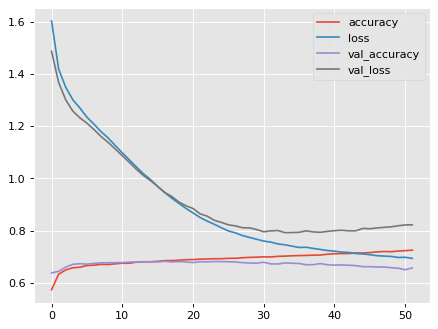

In [81]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [83]:
model.evaluate(X_test_scaled, ytest)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - accuracy: 0.6786 - loss: 0.9437


[0.9457158446311951, 0.6823499798774719]

In [85]:
model.evaluate(X_train_scaled, ytrain)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - accuracy: 0.7012 - loss: 0.9025


[0.898359477519989, 0.704200029373169]

In [88]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred_probabilities = model.predict(X_train)
    y_train_pred = y_train_pred_probabilities.argmax(axis=1)
    y_pred_probabilities = model.predict(X_test)
    y_pred = y_pred_probabilities.argmax(axis=1)

    print("Test Set:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("\nTrain Set:")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [89]:
eval_metric(model, X_train_scaled, ytrain, X_test_scaled, ytest)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
Test Set:
[[2190   39 1337]
 [ 440 3672 1687]
 [1557 1293 7785]]
              precision    recall  f1-score   support

           0       0.52      0.61      0.56      3566
           1       0.73      0.63      0.68      5799
           2       0.72      0.73      0.73     10635

    accuracy                           0.68     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.69      0.68      0.68     20000


Train Set:
[[ 8168   221  5873]
 [ 1099 15305  6795]
 [ 4509  5167 32863]]
              precision    recall  f1-score   support

           0       0.59      0.57      0.58     14262
           1       0.74      0.66      0.70     23199
           2       0.72      0.77      0.75     42539

    accuracy                           0.70     80000
   macro avg       0.68      0.67      0.68     80000
weighted avg       0.70      0.70      0.70     80000



In [90]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,563 (3.87 MB)

 Trainable params: 337,667 (1.29 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 675,336 (2.58 MB)

#### ================================= END OF CODE =================================